# Can ARIMA predict Currency Exchange Rates?

Joseph Nguyen's article from Investopedia.com [1] addresses methods for predicting currency exchange rates.  He states that no method has proven more successful and outlines the four most popular methods of forecasting.

Purchasing Power Parity (PPP) has traditionally been the economist's choice, as illustrated in the Big Mac Index [2].  This method requires data on the economic value of goods in addition to exchange rates.

The second method, Relative Economic Strength, is a supplemental method that compares interest rates between countries to anticipate whether the currency is going to appreciate or depreciate, and indicate the strength of the movement.  This method also requires interest rates data in addition to exchange rates.

The most complex models come with the third method of Econometrics, which compiles various data believed to be influential to the exchange rate.  The possibilities are endless on what might make a good feature and extensive study and/or domain knowledge is required to identify potentially useful data.

The final method is the simplest - time series.  This method uses only historical values to make predictions.  As covered by Mr Nguyen, the most popular time series model is ARIMA.

This investigation focuses on ARIMA.  

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pyramid.arima import auto_arima
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## Exchange Rate Data
For this analysis we will use the exchange rate for Euros to US Dollars.  Our dataset covers the initial use of the Euro in January 2002 through August 2018 [3].

In [2]:
# exchange rate data
USEU_raw = pd.read_csv('USD_EU.csv', header=5)

USEU_raw.head()

,Time Period,RXI$US_N.B.EU
0,2002-01-01,ND
1,2002-01-02,0.9031
2,2002-01-03,0.8992
3,2002-01-04,0.8946
4,2002-01-07,0.8931


In [3]:
# clean data

USEU_data = USEU_raw.copy()

# convert index to datetime
USEU_data['Date'] = pd.to_datetime(USEU_raw['Time Period'])

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_data['Rate'] = pd.to_numeric(USEU_data['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_data = USEU_data.drop(columns=['Time Period', 'RXI$US_N.B.EU'])

# Remove NAs and NDs
USEU_data.dropna(inplace=True)

# reset index to sequential from 0
USEU_data.reset_index(drop=True, inplace=True)

USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,4189.0,1.25222,0.141234,0.8594,1.1534,1.2684,1.3494,1.601


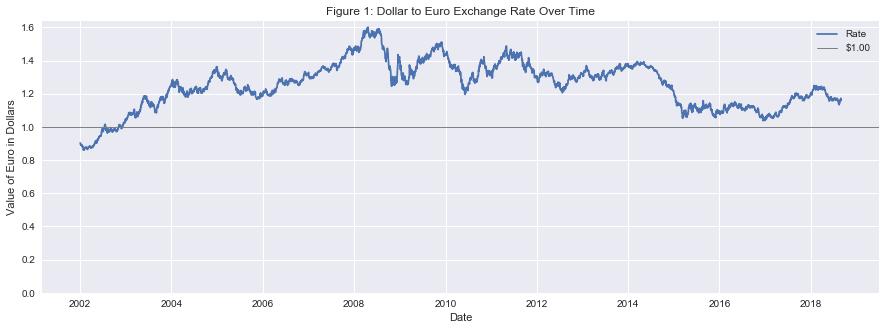

In [4]:
# plot data as time series

time_series = USEU_data.copy()
time_series.index = pd.to_datetime(time_series['Date'])
time_series = time_series.drop(columns=['Date'])

plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Rate')
plt.axhline(1, color='grey', linewidth=1, label="$1.00")
plt.title('Figure 1: Dollar to Euro Exchange Rate Over Time')
plt.ylim(bottom=0)
plt.legend()
plt.show()

The euro was first put in use on January 1, 2002.  The first date with data is the second day of use.  This plot of the exhange rate over time shows that the value of the Euro started below the dollar.  The Euro value was initially at 90 cents, then dipped lower, before surpassing the Dollar by the end of the first year of use.

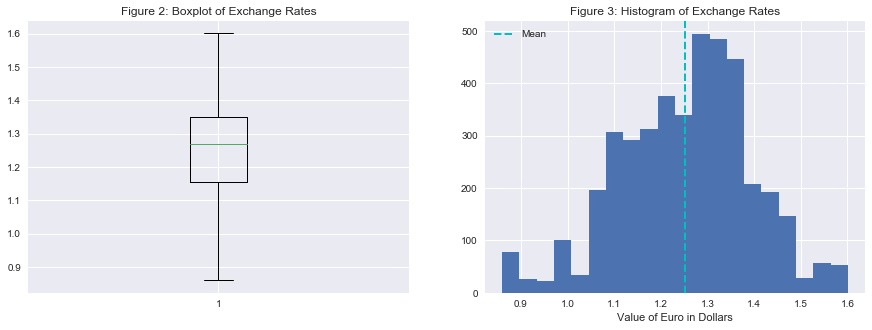

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate)
plt.title('Figure 2: Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate, bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Figure 3: Histogram of Exchange Rates')
plt.show()

There are no notable outliers, all values fit within the whiskers of the boxplot (Figure 2).  The histogram shape is very close to a bell (Figure 3).  The data is fairly normally distributed.

Since we know from the time plot that the lowest values were in the first year, let's isolate that first year of data and take a look.

In [6]:
USEU_2002 = USEU_data.copy()

# drop data from first year of euro use
USEU_2002 = USEU_2002[USEU_2002.Date < '2003-01-01']

USEU_2002.shape

(251, 2)

In [7]:
USEU_2002.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,251.0,0.945384,0.053321,0.8594,0.88605,0.9708,0.9875,1.0485


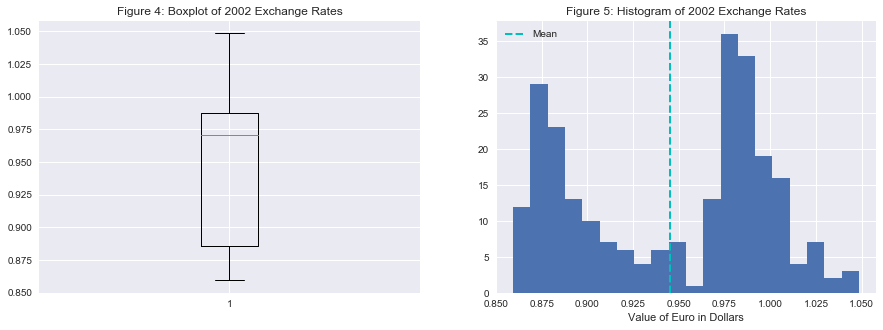

In [8]:
# Figure Two
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_2002.Rate)
plt.title('Figure 4: Boxplot of 2002 Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_2002.Rate, bins=20)
plt.axvline(USEU_2002.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Figure 5: Histogram of 2002 Exchange Rates')
plt.show()

The data from 2002 contains the lowest euro values, with a mean of about 95 cents.  This is notably outisde the range of the rest of the data.

**Euro value burn-in?** <br>
The Euro was first put into use in 2002 and we see the exchange values for this first year as gaining confidence against US currency.  We'll drop the first year of data to get a more established value of the exchange rate.

In [9]:
# drop data from first year of euro use
USEU_data = USEU_data[USEU_data.Date >= '2003-01-01']

# reset index to sequential from 0
USEU_data.reset_index(drop=True, inplace=True)

USEU_data.shape

(3938, 2)

In [10]:
USEU_data.head()

,Date,Rate
0,2003-01-02,1.0361
1,2003-01-03,1.0418
2,2003-01-06,1.0469
3,2003-01-07,1.0419
4,2003-01-08,1.0447


In [11]:
USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,3938.0,1.271777,0.121051,1.0361,1.178825,1.27795,1.353875,1.601


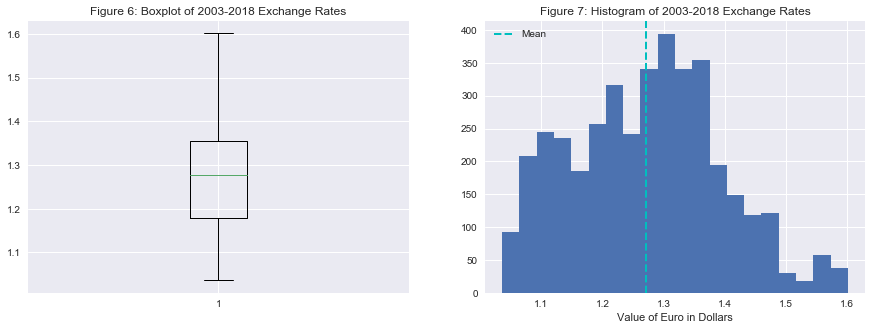

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate)
plt.title('Figure 6: Boxplot of 2003-2018 Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate, bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Figure 7: Histogram of 2003-2018 Exchange Rates')
plt.show()

Looking at the data from 2003 forward, we see a mean of 1.27 with a range from 1.04 to 1.60 - the boxplot shows no outliers, we have normal distribution.

## Time Series Analysis
The first step in working with our data is to look at the influence of time on the exchange rate.  We will take a closer look at the data as a time series in hopes of utilizing the impact of time on our data to model and predict.

In [13]:
# set time series
time_series = USEU_data.copy()
time_series.index = pd.to_datetime(time_series['Date'])
time_series = time_series.drop(columns=['Date'])

In [14]:
time_series.head()

,Rate
Date,
2003-01-02,1.0361
2003-01-03,1.0418
2003-01-06,1.0469
2003-01-07,1.0419
2003-01-08,1.0447


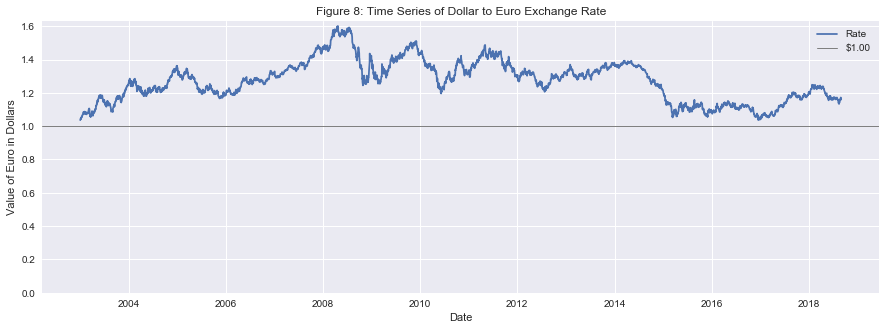

In [15]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Rate')
plt.axhline(1, color='grey', linewidth=1, label="$1.00")
plt.title('Figure 8: Time Series of Dollar to Euro Exchange Rate')
plt.ylim(bottom=0)
plt.legend()
plt.show()

The value of the euro generally increased from 2003 through 2008.  There are then erratic rates that generally trend down through 2015.  There is a significant drop in relative value of the Euro from late 2009 to mid 2010, then again from 2014 to early 2015.

### Stationarity
To further examine the data as a time series, we need to estalish stationarity, which allows us to isolate the variation over time.  The time-series plot makes it clear visually that our data is not stationary, in that it is not clustered around a single value.  By plotting the difference of each data point from the prior value, we should be able to see stationarity.

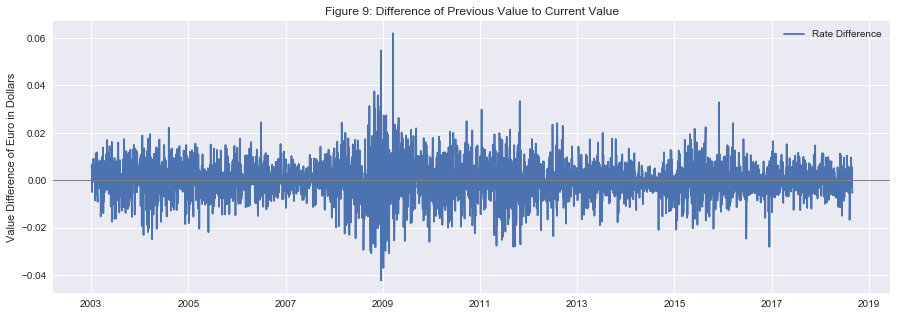

In [16]:
# difference of one record from previous
time_series['diff_1'] = time_series.Rate - time_series.Rate.shift()

plt.figure(figsize=(15, 5))
plt.plot(time_series.index, time_series.diff_1, label="Rate Difference")
plt.axhline(0, color='grey', linestyle='solid', linewidth=1)
plt.ylabel('Value Difference of Euro in Dollars')
plt.title('Figure 9: Difference of Previous Value to Current Value')
plt.legend()
plt.show()

This plot of difference shows the values custered around 0 - we have stationarity in the data when taking a single difference.  This plot gives us insight into how our data values change from day to day.  We see greater volatility in the exchange rate in 2008 and 2009, with noticeable smaller extremes after 2009, reflecting the economic instability of the time.  There is noticably more stability in the exchange rate in 2014 as less variation is seen from day to day.

We can mathematically test the stationarity of the data using a Dickey Fuller test.

In [17]:
# Use statsmodel's augmented Dicky Fuller test
series = time_series.Rate
X = series.values
result = adfuller(X)
print('Exchange Rate Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Dickey Fuller Test
Statistic: -2.403107
p-value: 0.140861
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [18]:
# Dicky Fuller test on the difference data
series = time_series.diff_1.dropna()
X = series.values
result = adfuller(X)
print('Exchange Rate Difference Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Difference Dickey Fuller Test
Statistic: -62.348214
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The Dickey Fuller test results show a much lower Statistic value for the differenced data, along with a much smaller p-value, indicating that the differenced data is stationary.  Just to be sure, let's check the second order difference (the difference of the difference) with Dickey Fuller.

In [19]:
# Dicky Fuller test on the second difference data
time_series['diff_2'] = time_series.diff_1 - time_series.diff_1.shift()
series = time_series.diff_2.dropna()
X = series.values
result = adfuller(X)
print('Exchange Rate Second Difference Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Exchange Rate Second Difference Dickey Fuller Test
Statistic: -18.877696
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The second-level difference has a higher Statistic, indicating reduced stationarity compared to the first difference.  We have confirmed that the first difference best establishes stationarity.

## Seasonality
Looking for recurring patterns in the data.

**Data by Year**

In [20]:
season = USEU_data.copy()
season['year'], season['month'], season['day'] = season['Date'].dt.year, season['Date'].dt.month, season['Date'].dt.day

In [21]:
season.head()

,Date,Rate,year,month,day
0,2003-01-02,1.0361,2003,1,2
1,2003-01-03,1.0418,2003,1,3
2,2003-01-06,1.0469,2003,1,6
3,2003-01-07,1.0419,2003,1,7
4,2003-01-08,1.0447,2003,1,8


In [22]:
season_series = season.copy()
season_series.index = pd.to_datetime(season_series['Date'])
season_series = season_series.drop(columns=['Date'])
season_series.head()

,Rate,year,month,day
Date,,,,
2003-01-02,1.0361,2003,1,2
2003-01-03,1.0418,2003,1,3
2003-01-06,1.0469,2003,1,6
2003-01-07,1.0419,2003,1,7
2003-01-08,1.0447,2003,1,8


In [23]:
season_series.groupby('year').describe()

Rate                                                                   \
      count      mean       std     min       25%      50%       75%     max   
year                                                                           
2003  251.0  1.132057  0.050493  1.0361  1.086550  1.13370  1.169500  1.2597   
2004  253.0  1.243817  0.043363  1.1801  1.211800  1.23060  1.268500  1.3625   
2005  251.0  1.244871  0.050607  1.1667  1.203750  1.22880  1.293700  1.3476   
2006  251.0  1.256293  0.037770  1.1860  1.216300  1.26730  1.279850  1.3327   
2007  254.0  1.371063  0.052929  1.2904  1.335900  1.36005  1.413325  1.4862   
2008  252.0  1.472560  0.102261  1.2446  1.414775  1.48365  1.558950  1.6010   
2009  252.0  1.393547  0.072267  1.2547  1.328075  1.40375  1.457400  1.5100   
2010  250.0  1.326090  0.059157  1.1959  1.282725  1.33295  1.365950  1.4536   
2011  251.0  1.393133  0.046384  1.2926  1.360300  1.39760  1.431950  1.4875   
2012  251.0  1.285874  0.033053  1.2062  1.258350  1.29400  1.312750  1.3463   
2013  251.0  1.328139  0.026735  1.2774  1.306600  1.32690  1.349200  1.3816   
2014  250.0  1.329671  0.052734  1.2101  1.277925  1.35515  1.370350  1.3927   
2015  251.0  1.109610  0.028484  1.0524  1.089500  1.11080  1.128450  1.2015   
2016  251.0  1.107194  0.025187  1.0375  1.093400  1.11400  1.125100  1.1516   
2017  249.0  1.130050  0.050961  1.0416  1.074900  1.13670  1.177800  1.2041   
2018  170.0  1.197586  0.032925  1.1332  1.167525  1.19630  1.230700  1.2488   

        day             ...               month                                \
      count       mean  ...    75%   max  count      mean       std  min  25%   
year                    ...                                                     
2003  251.0  15.800797  ...   23.0  31.0  251.0  6.509960  3.435535  1.0  4.0   
2004  253.0  15.786561  ...   23.0  31.0  253.0  6.541502  3.445041  1.0  4.0   
2005  251.0  15.701195  ...   23.0  31.0  251.0  6.505976  3.422713  1.0  4.0   
2006  251.0  15.820717  ...   23.0  31.0  251.0  6.509960  3.418026  1.0  4.0   
2007  254.0  15.799213  ...   23.0  31.0  254.0  6.523622  3.425871  1.0  4.0   
2008  252.0  15.781746  ...   23.0  31.0  252.0  6.492063  3.440435  1.0  4.0   
2009  252.0  15.682540  ...   23.0  31.0  252.0  6.527778  3.421752  1.0  4.0   
2010  250.0  15.596000  ...   23.0  31.0  250.0  6.520000  3.412945  1.0  4.0   
2011  251.0  15.701195  ...   23.0  31.0  251.0  6.505976  3.422713  1.0  4.0   
2012  251.0  15.892430  ...   23.5  31.0  251.0  6.486056  3.418012  1.0  4.0   
2013  251.0  15.729084  ...   23.0  31.0  251.0  6.498008  3.428556  1.0  4.0   
2014  250.0  15.760000  ...   23.0  31.0  250.0  6.488000  3.424729  1.0  4.0   
2015  251.0  15.733068  ...   23.0  31.0  251.0  6.525896  3.428458  1.0  4.0   
2016  251.0  15.760956  ...   23.0  31.0  251.0  6.509960  3.416855  1.0  4.0   
2017  249.0  15.827309  ...   23.0  31.0  249.0  6.514056  3.401969  1.0  4.0   
2018  170.0  15.800000  ...   23.0  31.0  170.0  4.564706  2.302286  1.0  3.0   

                       
      50%   75%   max  
year                   
2003  7.0  9.00  12.0  
2004  7.0  9.00  12.0  
2005  6.0  9.00  12.0  
2006  6.0  9.00  12.0  
2007  7.0  9.75  12.0  
2008  6.5  9.00  12.0  
2009  7.0  9.00  12.0  
2010  6.5  9.00  12.0  
2011  6.0  9.00  12.0  
2012  6.0  9.00  12.0  
2013  7.0  9.00  12.0  
2014  6.5  9.00  12.0  
2015  7.0  9.00  12.0  
2016  6.0  9.00  12.0  
2017  6.0  9.00  12.0  
2018  5.0  7.00   8.0  

[16 rows x 24 columns]

In [24]:
# compute average records per year
years = season_series.copy()
#remove 2018 as incomplete
years = years[years.year < 2018]
years.groupby('year').count().mean()

Rate     251.2
month    251.2
day      251.2
dtype: float64

The average number of records per year is 251, the same number of records found in the first year of use.

In [25]:
# calculate day of year [4]
season_series['doy'] = season_series.index.dayofyear

# pivot data to index by day of the year
piv = pd.pivot_table(season_series, index=['doy'],columns=['year'], values=['Rate'])

In [26]:
piv.head()

Rate                                                                  \
year    2003    2004    2005    2006    2007    2008    2009    2010    2011   
doy                                                                            
2     1.0361  1.2592     NaN     NaN  1.3286  1.4738  1.3946     NaN     NaN   
3     1.0418     NaN  1.3476  1.1980  1.3169  1.4736     NaN     NaN  1.3371   
4        NaN     NaN  1.3295  1.2091  1.3094  1.4786     NaN  1.4419  1.3306   
5        NaN  1.2679  1.3292  1.2101  1.3005     NaN  1.3576  1.4402  1.3171   
6     1.0469  1.2773  1.3187  1.2148     NaN     NaN  1.3445  1.4404  1.3027   

                                                              
year    2012    2013    2014    2015    2016    2017    2018  
doy                                                           
2        NaN  1.3195  1.3670  1.2015     NaN     NaN  1.2050  
3     1.3061  1.3110  1.3606     NaN     NaN  1.0416  1.2030  
4     1.2930  1.3047     NaN     NaN  1.0803  1.0476  1.2064  
5     1.2783     NaN     NaN  1.1918  1.0743  1.0598  1.2039  
6     1.2723     NaN  1.3636  1.1936  1.0762  1.0560     NaN

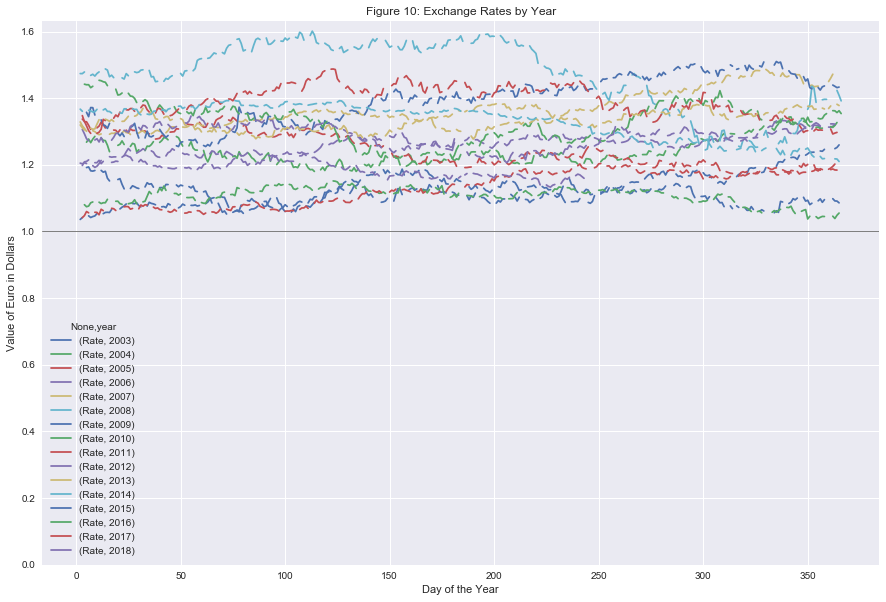

In [27]:
# plot pivot table
fig, ax = plt.subplots(figsize=(15, 10))
piv.plot(ax=ax)
plt.axhline(1, color='grey', linewidth=1, label="$1.00")
plt.ylabel('Value of Euro in Dollars')
plt.xlabel('Day of the Year')
plt.title('Figure 10: Exchange Rates by Year')
plt.ylim(bottom=0) 
plt.show()

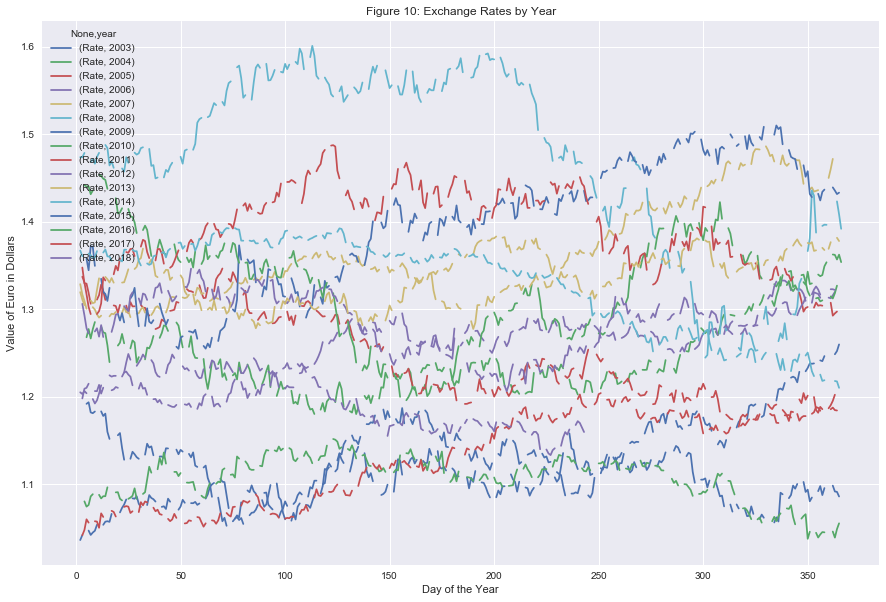

In [28]:
# plot pivot table
fig, ax = plt.subplots(figsize=(15, 10))
piv.plot(ax=ax)
plt.ylabel('Value of Euro in Dollars')
plt.xlabel('Day of the Year')
plt.title('Figure 10: Exchange Rates by Year')
plt.show()

Visualizing the exchange rate by each year, we see no recurring patterns to indicate seasonality; the records criss cross eachother with no repetition.  
Seasonality can also be explored through the Seasonal Decomposition package available through Statsmodels.  Either method results in the same conclusion, our data has no recurring seasonality, so we will work with a non-seasonal ARIMA model.

# Models

Now we have explored our data, we need to utilize our insights to design models that capture the data and test if those models can forecast future exchange rates.

To proceed, we will define training and test sets so we can train our model and test its efficacy.

### Training and Test
Separate data into train and test at 70/30 split.

In [29]:
# define training set from original data
train_size = int(len(USEU_data) * 0.70)
train, test = USEU_data[0:train_size], USEU_data[train_size:len(USEU_data)]

# define training set from time series data
series_train, series_test = time_series[0:train_size], time_series[train_size:len(USEU_data)]

print('Observations: %d' % (len(USEU_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 3938
Training Observations: 2756
Testing Observations: 1182


In [30]:
test.head()

,Date,Rate
2756,2013-12-16,1.3757
2757,2013-12-17,1.3748
2758,2013-12-18,1.3766
2759,2013-12-19,1.3666
2760,2013-12-20,1.3673


In [31]:
test.tail()

,Date,Rate
3933,2018-08-27,1.1676
3934,2018-08-28,1.1720
3935,2018-08-29,1.1699
3936,2018-08-30,1.1646
3937,2018-08-31,1.1596


Our Training data cover almost eleven years, from January 2003 to December 2013.  The Test set is just under five years, from December 2013 to August 2018 (index 2756-3937).

In [32]:
print('Training Data')
train.describe().transpose()

Training Data


,count,mean,std,min,25%,50%,75%,max
Rate,2756.0,1.31326,0.105697,1.0361,1.24195,1.3081,1.371575,1.601


In [33]:
print('Test Data')
test.describe().transpose()

Test Data


,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.0375,1.1038,1.1391,1.229775,1.3927


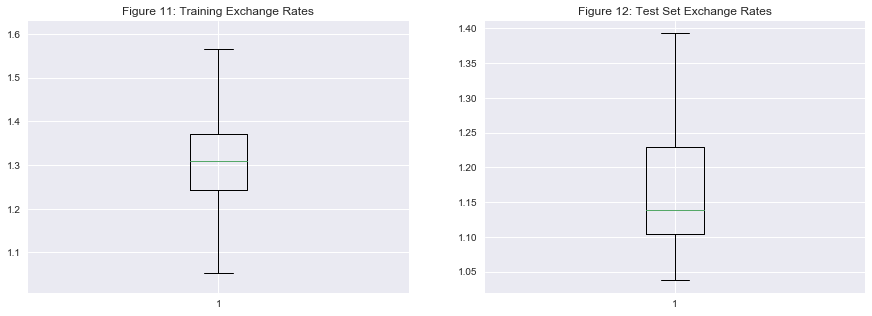

Training Data Mean: $1.31
Test Data Mean: $1.18


In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(train.Rate.dropna(how = 'any'))
plt.title('Figure 11: Training Exchange Rates')

plt.subplot(1, 2, 2)
plt.boxplot(test.Rate.dropna(how = 'any'))
plt.title('Figure 12: Test Set Exchange Rates')

plt.show()

print('Training Data Mean: $%.2f' % (train.Rate.mean()))
print('Test Data Mean: $%.2f' % (test.Rate.mean()))

These individual box plots of the training and test data show greater variation in the training set - with Euro values raging from just over 1.00 to over 1.60.  The test fits within that range, from 1.05 to 1.40.  <br>
The test set shows a stronger value for the dollar, as the average Euro rate is notable lower than in the training set.

## ARIMA model
The ARIMA model takes three parameters: <br>
AR for auto-regressive or how the data relates to it's prior values<br>
I for integrated or the level of differencing required to make the data stationary<br>
MA for moving average or how the data relates to prior errors

Since we saw stationarity in our data by taking the first difference (confirmed with our Dickey Fuller test), we will start with an integrated parameter of 1.  Now we need to find appropriate value for the AR and MA elements.

### AutoCorrelation Function (ACF) & Partial AutoCorrelation Function (PACF)
Comparing the exchange rate with a prior rates, testing for correlation.  Auto Correlation includes the impact of correlations between prior values, while the Partial Auto Correlation removes the impact of correlation to other prior values.  The values on the x-axis indicate the time-step shift.

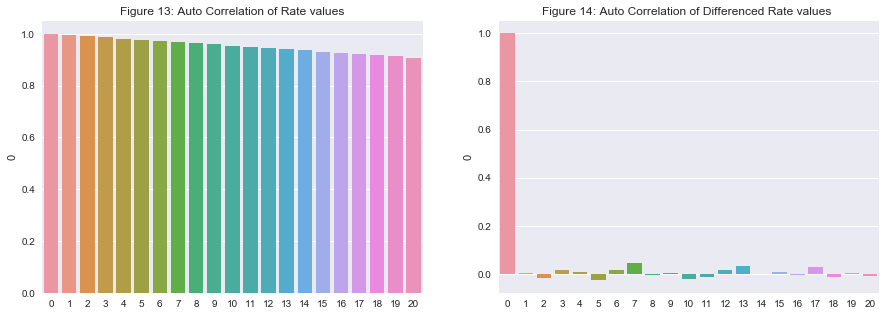

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_acf = pd.DataFrame(acf(series_train.Rate, nlags=20))
sns.barplot(x=x_acf.index, y=x_acf[0])
plt.title("Figure 13: Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_acf_diff = pd.DataFrame(acf(series_train.diff_1[1:], nlags=20))
sns.barplot(x=x_acf_diff.index, y=x_acf_diff[0])
plt.title("Figure 14: Auto Correlation of Differenced Rate values ")
plt.show()

The ACF of the original rates shows a gradual decline in correlations with increased time shifts (Figure 13).  The differenced data shows no auto correlation (Figure 14).

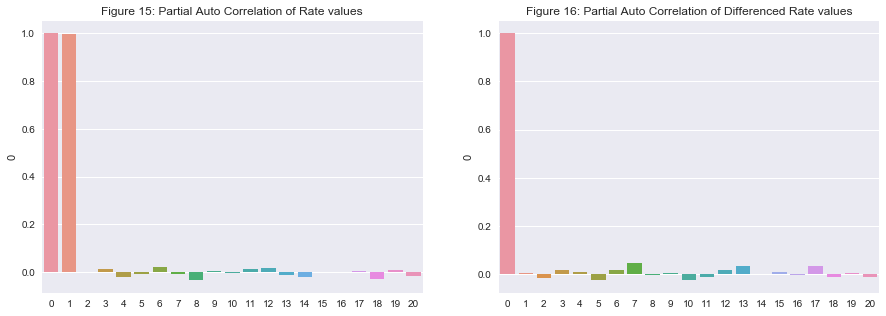

In [36]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_pacf = pd.DataFrame(pacf(series_train.Rate, nlags=20))
sns.barplot(x=x_pacf.index, y=x_pacf[0])
plt.title("Figure 15: Partial Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_pacf_diff = pd.DataFrame(pacf(series_train.diff_1[1:], nlags=20))
sns.barplot(x=x_pacf_diff.index, y=x_pacf_diff[0])
plt.title("Figure 16: Partial Auto Correlation of Differenced Rate values")
plt.show()

The PACF of the original exchange rate values shows strong auto-correlation at 1 (Figure 15).  The PACF of the exchange rate difference values shows no notable correlation (Figure 16).

These results indicate that AR and MA parameters of 0 will be well-suited to capturing our data.  We'll run some additional tests to find the best configuration for our model.

### Using Auto Arima to for optimal test parameters
Applying Pyramid's Auto Arima package, we will use the Akaike Information Criterion (AIC) to evaluate the order of our models.  The AIC measures how well our data is explained by the model, relative to how complex it is.

In [37]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-18441.104, BIC=-18429.261, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-18439.164, BIC=-18421.401, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-18439.166, BIC=-18421.402, Fit time=0.043 seconds
Total fit time: 0.414 seconds
-18441.103712277098


As anticipated, an ARIMA model with 0,1,0 configuration has the lowest AIC score on our initial test.  It is worth noting that the (1, 1, 0) and (0, 1, 1) also show AIC values very close to the (0, 1, 0) model.  This means each of these models are capturing the data with similar accuracy and parsimony.

Let's test some higher order models and see how they compare.

In [38]:
train_step_model = auto_arima(train.Rate, p=4, start_q=2,
                           max_q=3, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)
print(train_step_model.aic())

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2); AIC=-18437.215, BIC=-18395.767, Fit time=5.042 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2); AIC=-18435.327, BIC=-18387.957, Fit time=3.225 seconds
Fit ARIMA: order=(4, 1, 3); AIC=-18433.663, BIC=-18380.372, Fit time=2.665 seconds
Fit ARIMA: order=(5, 1, 2); AIC=-18433.351, BIC=-18380.060, Fit time=2.719 seconds
Fit ARIMA: order=(5, 1, 3); AIC=-18431.381, BIC=-18372.169, Fit time=2.465 seconds
Total fit time: 16.837 seconds
-18437.21523242889


Testing larger parameters for AR and MA we find that the AIC scores are all within a small range.  The (0,1,0) AIC of -18441.104 is only slightly lower than the (3,1,2) AIC of -18437.215 - any of the models might work well for our data.

Let's check on models using second order differencing (I of 2).

In [39]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, seasonal=False,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(1, 2, 1); AIC=-18409.738, BIC=-18386.055, Fit time=1.093 seconds
Fit ARIMA: order=(0, 2, 0); AIC=-16537.674, BIC=-16525.833, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0); AIC=-17292.532, BIC=-17274.770, Fit time=0.053 seconds
Fit ARIMA: order=(0, 2, 1); AIC=-18410.152, BIC=-18392.389, Fit time=0.663 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=-18423.269, BIC=-18393.664, Fit time=3.618 seconds
Fit ARIMA: order=(2, 2, 2); AIC=-18414.372, BIC=-18378.848, Fit time=6.564 seconds
Fit ARIMA: order=(1, 2, 3); AIC=-18404.859, BIC=-18369.334, Fit time=2.057 seconds
Fit ARIMA: order=(2, 2, 3); AIC=-18399.697, BIC=-18358.251, Fit time=4.540 seconds
Total fit time: 18.601 seconds
-18423.268523576357


Now we're seeing some higher AICs, perhaps more likely due to the increased complexity of the models, than an issue of accuracy.  The lowest AIC comes from the (1,2,2) model, at -18423.269 it less than 0.1% higher than the (3,1,2) model.

### Training the Model

In [40]:
# fit the model
model_010 = ARIMA(train.Rate, order=(0,1,0))
fit_010 = model_010.fit()
print(fit_010.summary())
print('Residuals Description')
print(fit_010.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(0, 1, 0)   Log Likelihood                9222.552
Method:                           css   S.D. of innovations              0.009
Date:                Wed, 03 Oct 2018   AIC                         -18441.104
Time:                        22:45:50   BIC                         -18429.261
Sample:                             1   HQIC                        -18436.826
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.753      0.452      -0.000       0.000
Residuals Description
count    2.755000e+03
mean     2.919964e-10
std      8.511597e-03
min     -4.242207e-02
25%     -4.522069e-03

In [41]:
# fit the model
model_011 = ARIMA(train.Rate, order=(0,1,1))
fit_011 = model_011.fit()
print(fit_011.summary())
print('Residuals Description')
print(fit_011.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(0, 1, 1)   Log Likelihood                9222.583
Method:                       css-mle   S.D. of innovations              0.009
Date:                Wed, 03 Oct 2018   AIC                         -18439.166
Time:                        22:45:50   BIC                         -18421.402
Sample:                             1   HQIC                        -18432.749
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.749      0.454      -0.000       0.000
ma.L1.D.Rate     0.0048      0.019      0.249      0.803      -0.033       0.043
                                    Roots   

In [42]:
# fit the model
model_312 = ARIMA(train.Rate, order=(3,1,2))
fit_312 = model_312.fit()
print(fit_312.summary())
print('Residuals Description')
print(fit_312.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(3, 1, 2)   Log Likelihood                9226.550
Method:                       css-mle   S.D. of innovations              0.008
Date:                Wed, 03 Oct 2018   AIC                         -18439.100
Time:                        22:45:56   BIC                         -18397.652
Sample:                             1   HQIC                        -18424.127
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.748      0.455      -0.000       0.000
ar.L1.D.Rate     0.2761      0.035      7.790      0.000       0.207       0.346
ar.L2.D.Rate    -0.9845      0.022    -44.48

In [43]:
# fit the model
model_122 = ARIMA(train.Rate, order=(1,2,2))
fit_122 = model_122.fit()
warnings.filterwarnings("ignore")
print(fit_122.summary())
print('Residuals Description')
print(fit_122.resid.describe())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D2.Rate   No. Observations:                 2754
Model:                 ARIMA(1, 2, 2)   Log Likelihood                9216.642
Method:                       css-mle   S.D. of innovations              0.009
Date:                Wed, 03 Oct 2018   AIC                         -18423.284
Time:                        22:46:01   BIC                         -18393.680
Sample:                             2   HQIC                        -18412.589
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.753e-07   2.04e-07     -0.858      0.391   -5.76e-07    2.25e-07
ar.L1.D2.Rate    -0.9850      0.013    -76.714      0.000      -1.010      -0.960
ma.L1.D2.Rate    -0.0093      0.010     

### Testing Model Fit

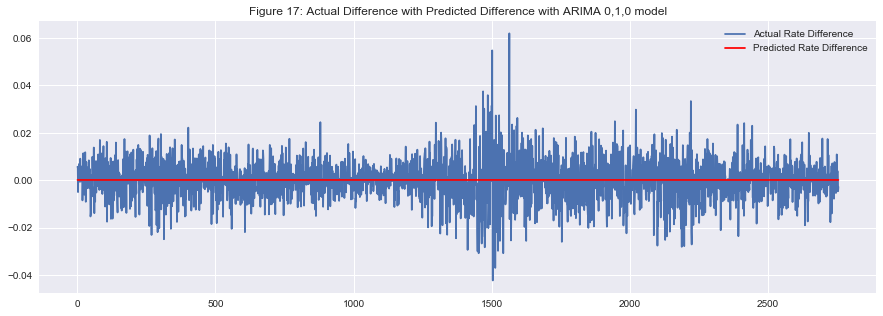

In [44]:
# comparing the model to the actual training data [5]
train['diff_1'] = train.Rate - train.Rate.shift()
 
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_010.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Figure 17: Actual Difference with Predicted Difference with ARIMA 0,1,0 model')
warnings.filterwarnings("ignore")
plt.show()

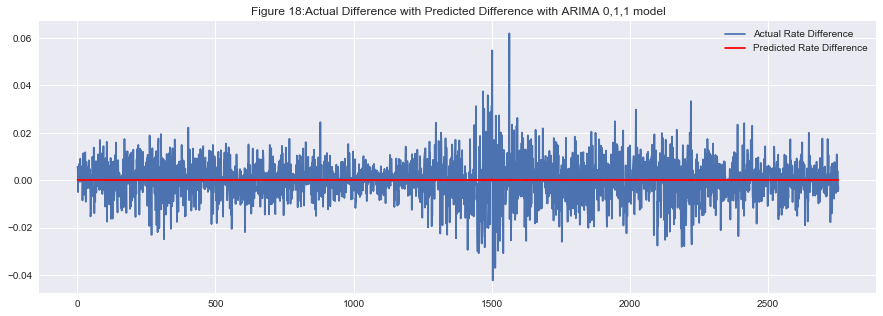

In [45]:

plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_011.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Figure 18:Actual Difference with Predicted Difference with ARIMA 0,1,1 model')
plt.show()

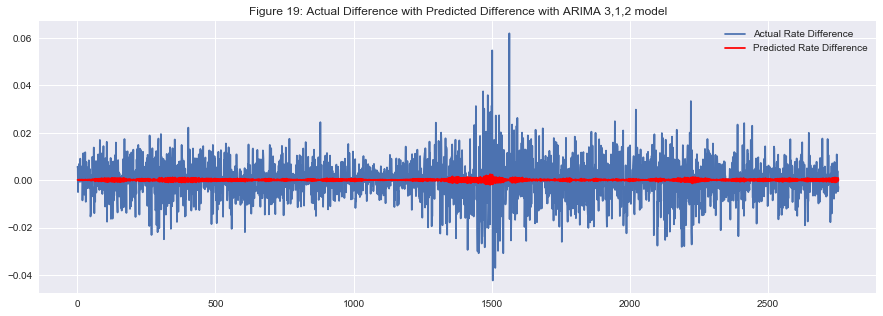

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_312.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Figure 19: Actual Difference with Predicted Difference with ARIMA 3,1,2 model')
plt.show()

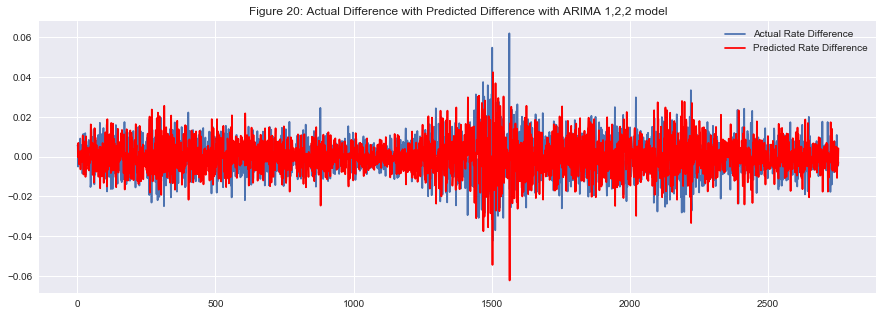

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_122.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Figure 20: Actual Difference with Predicted Difference with ARIMA 1,2,2 model')
plt.show()

The (0,1,0) and (0,1,1) models seem to capture little of the varibility of the data as the difference they capture appears consistent over time (Figures 17 and 18)
The (1, 2, 2) model seems to capture the variability of the data, but likely indicates overfitting (Figure 20).
The (3,1,2) model appears to capture some variability, but without apparent overfitting.

# Prediction

**Out of Sample Forecasting** <br>
Predicting values for the test range and comparing to actual values

In [48]:
# prediction (test) index range
start_index = 2756
end_index = 3937

### Predicting values with ARIMA (0, 1, 0) model.

In [49]:
# add predictions to data in new dataframe
future_forecast = fit_010.predict(start=start_index, end=end_index, dynamic=True)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict_010'])
test_predict = pd.concat([test, future_forecast], axis=1)

# calculate first predicted value
test_predict.loc[2756, ('Rate_010')] = train.loc[2755, ('Rate')] + test_predict.loc[2756, ('predict_010')]

#calculate remaining values
for i in range(start_index+1, end_index):
    old_rate = test_predict.loc[(i-1), ('Rate_010')]
    current_pred = test_predict.loc[i, ('predict_010')]
    new_rate = old_rate + current_pred
    test_predict.loc[i, ('Rate_010')] = new_rate

# creating time series of test and prediction
predict_series_010 = test_predict.copy()
predict_series_010.index = pd.to_datetime(predict_series_010['Date'])

# describe time series data
predict_series_010.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_010,1182.0,0.000122,0.000000,0.000122,0.000122,0.000122,0.000122,0.000122
Rate_010,1181.0,1.444543,0.041634,1.372522,1.408532,1.444543,1.480553,1.516563


In [50]:
predict_series_010.head()

,Date,Rate,predict_010,Rate_010
Date,,,,
2013-12-16,2013-12-16,1.3757,0.000122,1.372522
2013-12-17,2013-12-17,1.3748,0.000122,1.372644
2013-12-18,2013-12-18,1.3766,0.000122,1.372766
2013-12-19,2013-12-19,1.3666,0.000122,1.372888
2013-12-20,2013-12-20,1.3673,0.000122,1.373010


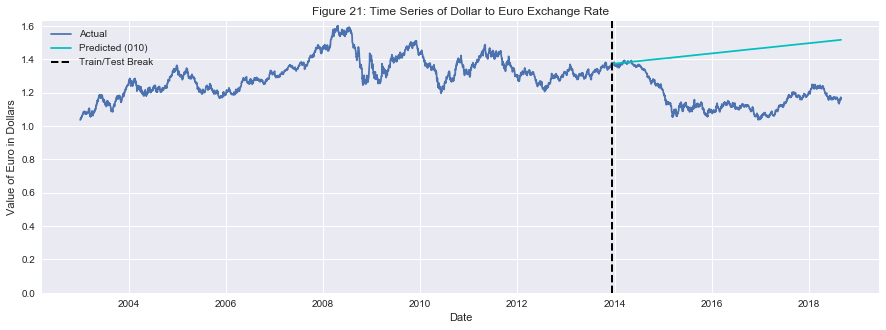

In [51]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series_010.Rate_010, label='Predicted (010)', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Figure 21: Time Series of Dollar to Euro Exchange Rate')
plt.ylim(bottom=0) 
plt.legend()
plt.show()

We see the predictions of our ARIMA (0,1,0) model appear as an increasing straight line.  Let's look at the first difference of our actual data compared to the predicted difference.

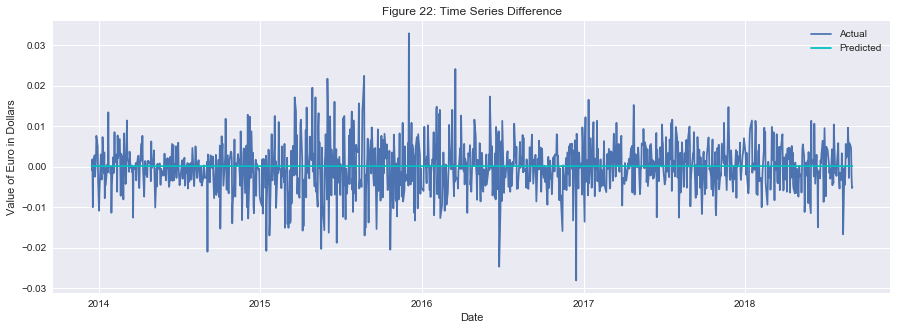

In [52]:
series_test['diff_1'] = series_test.Rate - series_test.Rate.shift()

# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(series_test.diff_1, label='Actual')
plt.plot(predict_series_010.predict_010, label='Predicted', color='c')
plt.title('Figure 22: Time Series Difference')
plt.legend()
warnings.filterwarnings("ignore")
plt.show()

Our model clearly does not capture the variation in our data.  Let's look at the residuals.

In [54]:
# calculate residuals 
predict_series_010['resid_010'] = predict_series_010.Rate - predict_series_010.Rate_010

predict_series_010.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_010,1182.0,0.000122,0.000000,0.000122,0.000122,0.000122,0.000122,0.000122
Rate_010,1181.0,1.444543,0.041634,1.372522,1.408532,1.444543,1.480553,1.516563
resid_010,1181.0,-0.269477,0.122185,-0.426818,-0.344302,-0.313205,-0.264569,0.012976


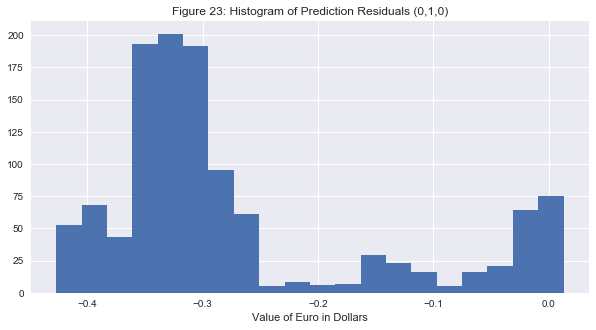

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlabel('Value of Euro in Dollars')
predict_series_010['resid_010'].hist(ax=ax, bins=20)
plt.title('Figure 23: Histogram of Prediction Residuals (0,1,0)')
plt.show()

This histogram of the residuals reinforces the conclusion that our predictions are not very accurate.  We have a cluster of small residuals, with the vast majority of residuals well over 25 cents.<br>
Now let's look at these residuals over time.

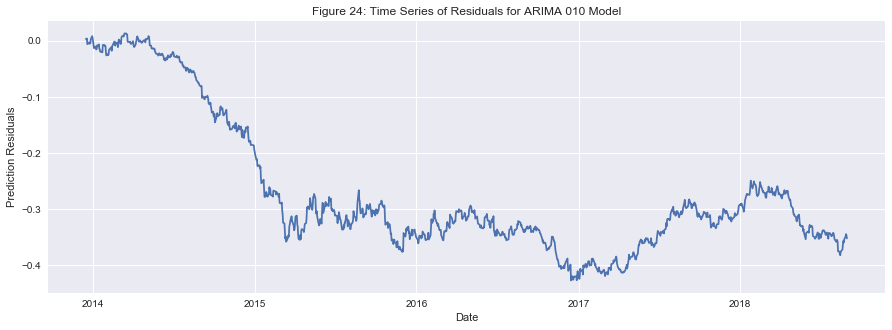

In [56]:
# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series_010.resid_010)
plt.title('Figure 24: Time Series of Residuals for ARIMA 010 Model')
plt.show()

By examining the residuals of our predictions as a time series, we can clearly see that our initial predictions, into 2014, are reasonably accurate.  We can also see that this model is not able to predict the increasing value of the dollar from 2014-2015, resulting in a disparity of over 40 cents in late 2016 and early 2017.  The (0,1,0) model is not able to capture the variation in the data caused by the variety of factors that influence exchange rates.

### Predicting values with the ARIMA (1, 2, 2) model.

In [57]:
# add predictions to data in new dataframe
forecast_122 = fit_122.predict(start=start_index, end=end_index, dynamic=True)
forecast_122 = pd.DataFrame(forecast_122,index = test.index,columns=['predict_122'])
test_predict_122 = pd.concat([test, forecast_122], axis=1)
test_predict_122.head()

,Date,Rate,predict_122
2756,2013-12-16,1.3757,0.002990
2757,2013-12-17,1.3748,-0.000610
2758,2013-12-18,1.3766,0.000601
2759,2013-12-19,1.3666,-0.000592
2760,2013-12-20,1.3673,0.000583


In [58]:
# calculate first two predicted value
test_predict_122.loc[2756, ('Rate_122')] = train.loc[2755, ('Rate')] + test_predict_122.loc[2756, ('predict_122')]
test_predict_122.loc[2757, ('Rate_122')] = train.loc[2755, ('Rate')] + test_predict_122.loc[2756, ('predict_122')] + test_predict_122.loc[2757, ('predict_122')] 


#calculate remaining values
for i in range(start_index+2, end_index):
    old_rate = test_predict_122.loc[(i-2), ('Rate_122')]
    old_predict = test_predict_122.loc[(i-1), ('predict_122')]
    current_pred = test_predict_122.loc[i, ('predict_122')]
    new_rate = old_rate + old_predict + current_pred
    test_predict_122.loc[i, ('Rate_122')] = new_rate
test_predict_122.head()

,Date,Rate,predict_122,Rate_122
2756,2013-12-16,1.3757,0.002990,1.375390
2757,2013-12-17,1.3748,-0.000610,1.374779
2758,2013-12-18,1.3766,0.000601,1.375380
2759,2013-12-19,1.3666,-0.000592,1.374788
2760,2013-12-20,1.3673,0.000583,1.375371


In [59]:
predict_series_122 = test_predict_122.copy()
predict_series_122.index = pd.to_datetime(predict_series_122['Date'])
predict_series_122.head()

,Date,Rate,predict_122,Rate_122
Date,,,,
2013-12-16,2013-12-16,1.3757,0.002990,1.375390
2013-12-17,2013-12-17,1.3748,-0.000610,1.374779
2013-12-18,2013-12-18,1.3766,0.000601,1.375380
2013-12-19,2013-12-19,1.3666,-0.000592,1.374788
2013-12-20,2013-12-20,1.3673,0.000583,1.375371


In [60]:
predict_series_122.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800e+00,1.139100e+00,1.229775e+00,1.39270
predict_122,1182.0,0.000002,0.000135,-0.000610,-2.544220e-07,-1.753299e-07,-9.503000e-08,0.00299
Rate_122,1181.0,1.374979,0.000079,1.374779,1.374923e+00,1.374972e+00,1.375019e+00,1.37539


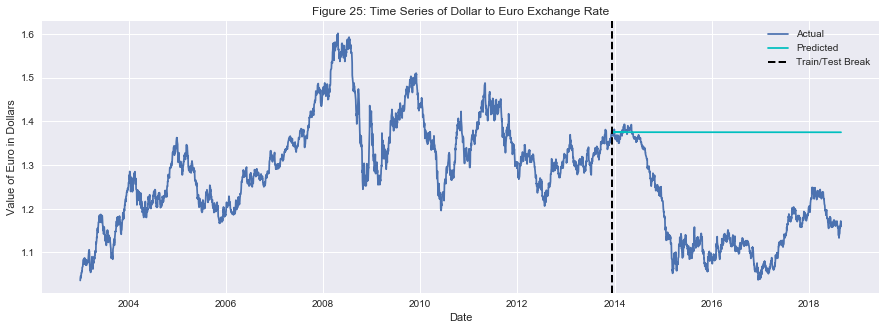

In [61]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series_122.Rate_122, label='Predicted', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Figure 25: Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

As with the (0,1,0) model, the predictions of the (1,2,2) appear as a striaght line, in this case the rate is stationary.  

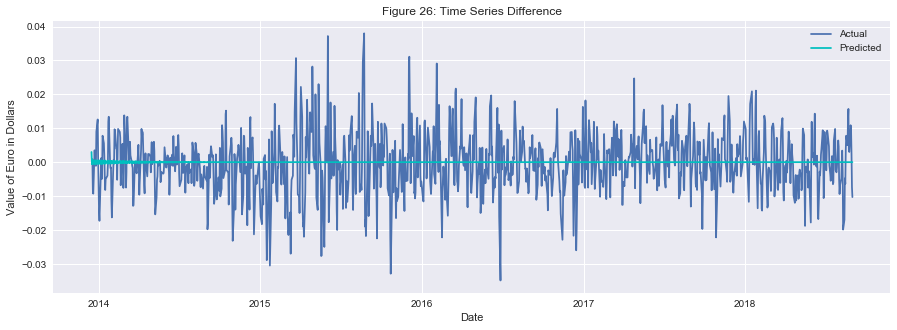

In [62]:
series_test['diff_2'] = series_test.Rate - series_test.Rate.shift(2)

# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(series_test.diff_2, label='Actual')
plt.plot(predict_series_122.predict_122, label='Predicted', color='c')
plt.title('Figure 26: Time Series Difference')
plt.legend()
warnings.filterwarnings("ignore")
plt.show()

While there is initially some notable variation from day to day, the overall trend is to maintain the exchange rate.

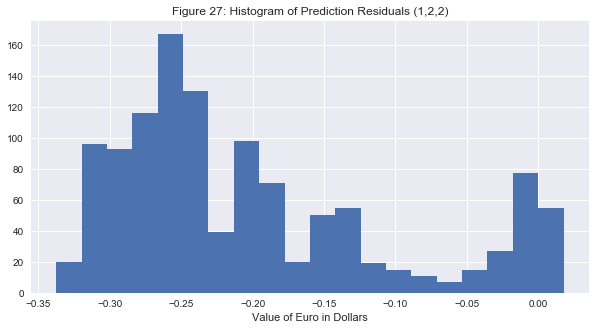

In [64]:
# calculate residuals
predict_series_122['resid_122'] = predict_series_122.Rate - predict_series_122.Rate_122

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlabel('Value of Euro in Dollars')
predict_series_122['resid_122'].hist(ax=ax, bins=20)
plt.title('Figure 27: Histogram of Prediction Residuals (1,2,2)')
plt.show()

Like our previous model, the (1,2,2) model shows a cluster of small residuals.  The histogram also shows a smaller range, with some additional clusters around 15 and 20 cents.

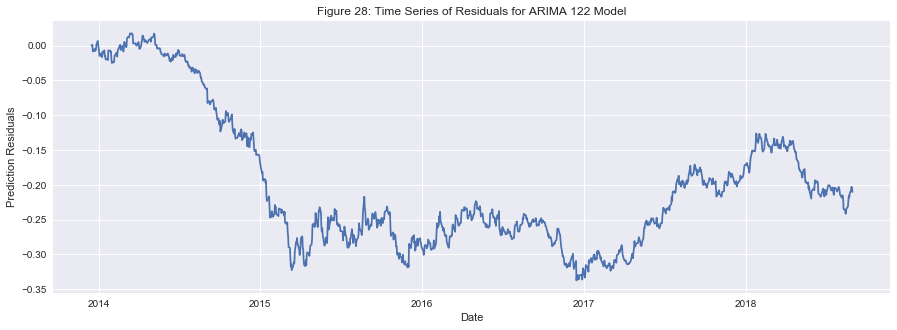

In [65]:
# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series_122.resid_122)
plt.title('Figure 28: Time Series of Residuals for ARIMA 122 Model')
plt.show()

As with the (0,1,0) model the (1,2,2) model is also unable to predict the relative decrease in the value of the Euro, but because of the flat trend, the residuals are slightly better at less than 35 cents.

### Predicting values with the ARIMA (3, 1, 2) model.

In [66]:
# add predictions to data in new dataframe
future_forecast_312 = fit_312.predict(start=start_index, end=end_index, dynamic=True)
future_forecast_312 = pd.DataFrame(future_forecast_312,index = test.index,columns=['predict_312'])
test_predict_312 = pd.concat([test, future_forecast_312], axis=1)

# calculate first predicted value
test_predict_312.loc[2756, ('Rate_312')] = train.loc[2755, ('Rate')] + test_predict_312.loc[2756, ('predict_312')]

#calculate remaining values
for i in range(start_index+1, end_index):
    old_rate = test_predict_312.loc[(i-1), ('Rate_312')]
    current_pred = test_predict_312.loc[i, ('predict_312')]
    new_rate = old_rate + current_pred
    test_predict_312.loc[i, ('Rate_312')] = new_rate

# creating time series of test and prediction
predict_series_312 = test_predict_312.copy()
predict_series_312.index = pd.to_datetime(predict_series_312['Date'])

# describe time series data
predict_series_312.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_312,1182.0,0.000122,0.000117,-0.000708,0.000121,0.000122,0.000123,0.000863
Rate_312,1181.0,1.444096,0.041638,1.371692,1.408110,1.444095,1.480109,1.516122


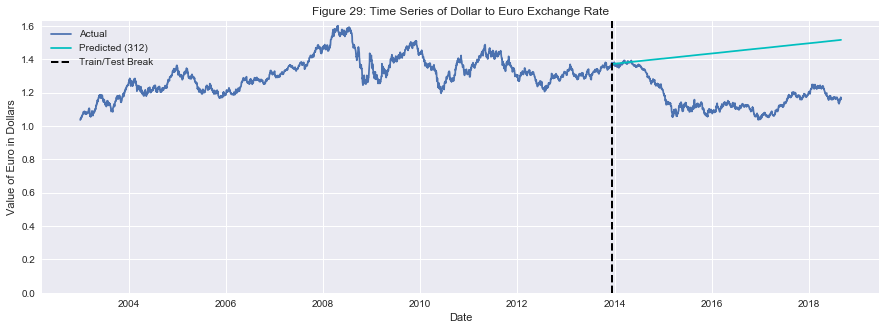

In [67]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series_312.Rate_312, label='Predicted (312)', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Figure 29: Time Series of Dollar to Euro Exchange Rate')
plt.ylim(bottom=0) 
plt.legend()
plt.show()

As with our prior efforts, the (3,1,2) model predictions appear as a straight line, this one increasing like the (0,1,0) predictions.  Let's plot the difference to better see how the predictions vary over time.

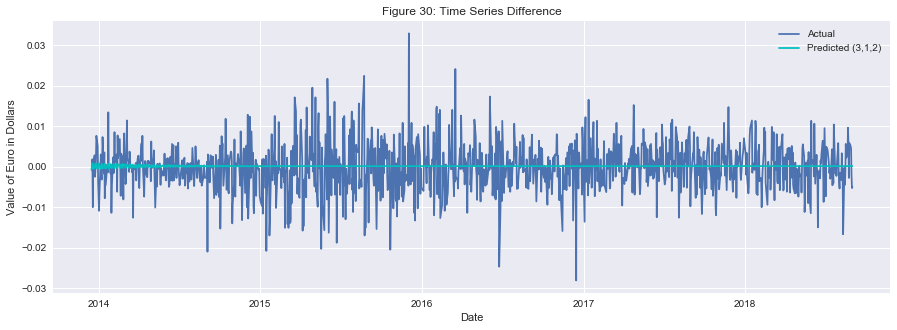

In [68]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(series_test.diff_1, label='Actual')
plt.plot(predict_series_312.predict_312, label='Predicted (3,1,2)', color='c')
plt.title('Figure 30: Time Series Difference')
plt.legend()
warnings.filterwarnings("ignore")
plt.show()

Here we see there is greater variation in the predictions in 2014, but that variation does not capture the actual data.

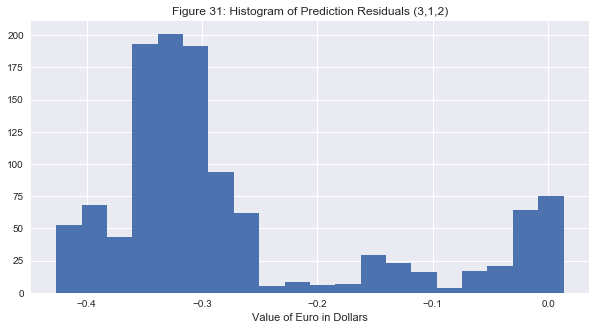

In [69]:
# calculate residuals
predict_series_312['resid_312'] = predict_series_312.Rate - predict_series_312.Rate_312

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlabel('Value of Euro in Dollars')
predict_series_312['resid_312'].hist(ax=ax, bins=20)
plt.title('Figure 31: Histogram of Prediction Residuals (3,1,2)')
plt.show()

Just like the (0,1,0) residual, we find a cluster of small residuals, with the majority over 25 cents.

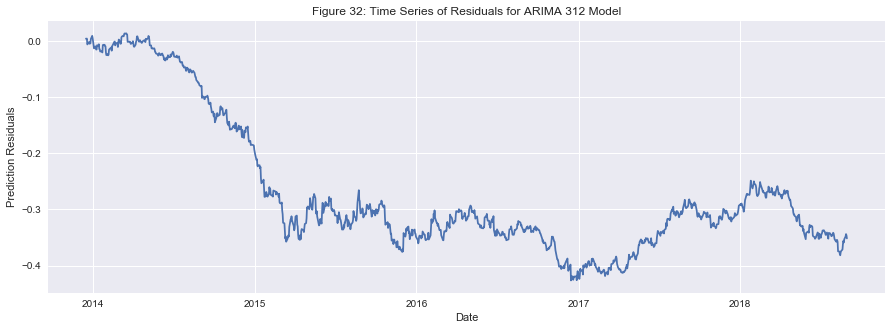

In [70]:
# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series_312.resid_312)
plt.title('Figure 32: Time Series of Residuals for ARIMA 312 Model')
plt.show()

As with our previous models, the (3,1,2) model shows small residuals for the first nine months, followed by increasing residuals, maxing out at over 40 cents.  The variation in the actual data exceeds the forecasting ability of the model.

Is one of these models more successful than the others?

## Comparing Residuals

### Using Mean Squared Errors to interpret prediction accuracy

In [71]:
# collect model residuals
mse = predict_series_010.copy()
mse = mse.drop(columns=['Date', 'Rate', 'predict_010', 'Rate_010'])
mse['resid_122'] = predict_series_122.resid_122
mse['resid_312'] = predict_series_312.resid_312
mse.head()

# square errors
mse['sq_010'] = mse.resid_010**2
mse['sq_122'] = mse.resid_122**2
mse['sq_312'] = mse.resid_312**2

mse = mse.drop(columns=['resid_010', 'resid_122', 'resid_312'])

# calculate MSE for each model
mse.mean().transpose()

sq_010    0.087535
sq_122    0.049368
sq_312    0.087295
dtype: float64

In calulating the mean squared errors of our models, we find that the ARIMA (1,2,2) had the best accuracy in prediction, while the (0,1,0) and (3,1,2) models have very similar accuracy.  <br>
This is visually intuitive from our time series plots of the predictions, where the (0,1,0) and (3,1,2) predictions appear almost identical (Figure 21 and Figure 29).

### Visualizing Prediction Residuals

In [72]:
ps010 = predict_series_010.copy()
ps010 = ps010.drop(columns=['Date', 'Rate', 'predict_010', 'Rate_010'])
ps122 = predict_series_122.copy()
ps122 = ps122.drop(columns=['Date', 'Rate', 'predict_122', 'Rate_122'])
ps312 = predict_series_312.copy()
ps312 = ps312.drop(columns=['Date', 'Rate', 'predict_312', 'Rate_312'])

res_result = pd.concat([ps010, ps122, ps312], axis=1)
res_result.head()

,resid_010,resid_122,resid_312
Date,,,
2013-12-16,0.003178,0.000310,0.004008
2013-12-17,0.002156,0.000021,0.003107
2013-12-18,0.003834,0.001220,0.004044
2013-12-19,-0.006288,-0.008188,-0.006389
2013-12-20,-0.005710,-0.008071,-0.005167


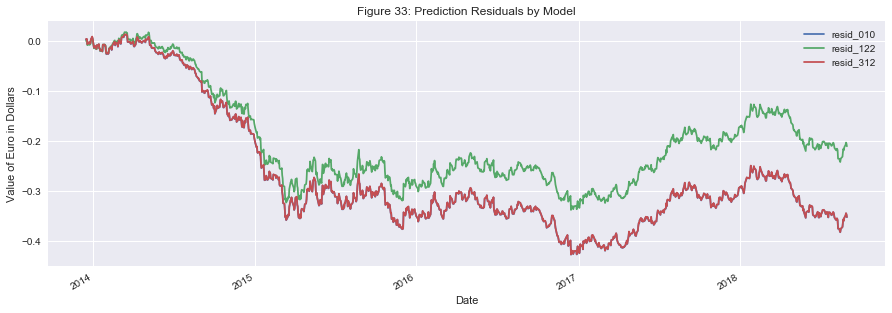

In [73]:
# plot time series
fig, ax = plt.subplots(figsize=(15, 5))
res_result.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.title('Figure 33: Prediction Residuals by Model')
#plt.legend()
plt.show()

Here we see that the models show very similar accuracy in the first nine months.  The (0,1,0) and (3,1,2) models continue to appear almost identical throughout the test range.

In [74]:
# collect actual and predicted rates in dataframe
st = series_test.copy()
st = st.drop(columns=['diff_1', 'diff_2'])
p010 = predict_series_010.copy()
p010 = p010.drop(columns=['Date', 'Rate', 'predict_010', 'resid_010'])
p122 = predict_series_122.copy()
p122 = p122.drop(columns=['Date', 'Rate', 'predict_122', 'resid_122'])
p312 = predict_series_312.copy()
p312 = p312.drop(columns=['Date', 'Rate', 'predict_312', 'resid_312'])

results = pd.concat([st, p010, p122, p312], axis=1)
results.head()

,Rate,Rate_010,Rate_122,Rate_312
Date,,,,
2013-12-16,1.3757,1.372522,1.375390,1.371692
2013-12-17,1.3748,1.372644,1.374779,1.371693
2013-12-18,1.3766,1.372766,1.375380,1.372556
2013-12-19,1.3666,1.372888,1.374788,1.372989
2013-12-20,1.3673,1.373010,1.375371,1.372467


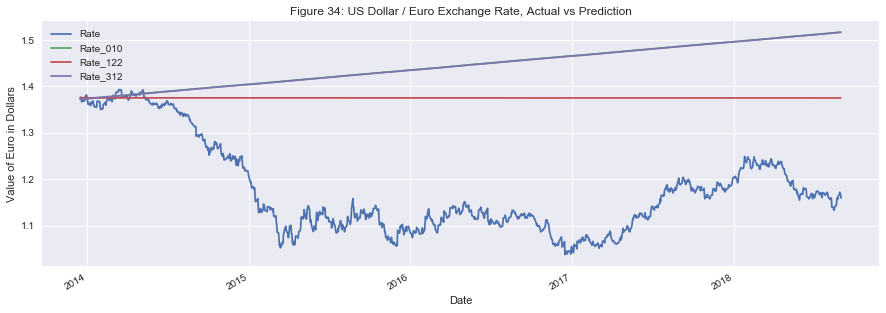

In [75]:
# plot time series
fig, ax = plt.subplots(figsize=(15, 5))
results.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.title('Figure 34: US Dollar / Euro Exchange Rate, Actual vs Prediction')
#plt.legend()
plt.show()

The actual Euro value had a dramatic decrease in the first year of the test period, while two of our three models predicted increases.  This leaves the almost stationary predictions of the (1,2,2) model to appear most accurate.

# Concusion

An ARIMA model can be used to predict currency exchange rates, but the limited nature of the model - using only the historical exchange rates - makes for limited forecasting efficacy.  In this exploration, we found similar accuracy in our predictions early in the test set.  The ARIMA model is not able to account for the additional factors that impact exchange rates over time.  Additional data, from Purchasing Power to Relative Economic Strength and more, is likely necessary to capture the influences on currency value over extended periods.

# Topics for Further Exploration

### Alternative Applications
**Rolling Forecast** <br>
In this exploration we used ARIMA for long-term predictions and saw that we were not able to anticpate significant changes in relative currency value.  But we also saw that the initial predictions were close to the actual exchange rates.  This may then be the better use of ARIMA, not to forecast far into the future, but to make smaller-scale predictions and to regularly add new data to the model to inform new exchange rate forecasts.

### Alternative Methods

**Bayesian Structural Time Series Models** <br>
As described by Kim Larsen from Stitch Fix, a Bayesian structural time series model can be used for time series predictions.  This allows for greater transparency in the model because it does not rely on differencing, lags and moving averages. [6]


**Other Regression Models** <br>
Given the discovery that the exchange rate data is normally distributed, any other regression models might be used for predictions.  The date data might be used to create features and predict future values, even without the use of additional data types.


**Facebook's Prophet** <br>
While ARIMA is the most common time series model, Facebook's Prophet is another time series model that might be used in place of ARIMA.  This additive model has been gaining in popularity. [7]


<br>
<br>
<br>

**References**

[1] *4 Ways to Forcast Exchange Rates* by Joseph Nguyen from 
https://www.investopedia.com/articles/forex/11/4-ways-to-forecast-exchange-rates.asp

[2] *Big Mac PP* from https://www.investopedia.com/terms/b/bigmacppp.asp

[3] *US Federal Reserve Exchange Rates* from https://www.federalreserve.gov/data.htm

[4] *Plot each year of a time series on the same x-axis using Pandas* by Andrew Tedstone from http://atedstone.github.io/pandas-plot-seasons-time-series/

[5] *A comprehensive Beginner's Guide to Time Series Forecasting* by Aarshay Jain from 
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

[6] *Sorry ARIMA, but I’m Going Bayesian* by Kim Larsen from https://www.predictiveanalyticsworld.com/patimes/sorry-arima-but-im-going-bayesian/7565/

[7] *Time Series Analysis in Python* by William Koehrsen from https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
